# Process AIS Dataset

## Setup

In [ ]:
import pandas as pd
import geopandas as gpd
from os.path import join, expanduser
from geopy import distance
import boto3

pd.set_option("display.max_columns", None)

: 

In [2]:
import sys

gn_path = join(expanduser("~"), "Repos", "GOSTnets")
sys.path.append(gn_path)

In [3]:
import GOSTnets as gn
import osmnx as ox
import pickle

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False, nb_workers=60)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Read Data

In [6]:
s3_client = boto3.client("s3")

In [7]:
objects = s3_client.list_objects_v2(
    Bucket="wbgdecinternal-ntl", Prefix="Andres_Temp/AIS/red-sea"
)

In [8]:
s3_files = []
for obj in objects["Contents"]:
    # print(obj["Key"])
    s3_files.append(obj["Key"])

In [9]:
# s3_files = s3_files[0:6] + s3_files[9:12] + s3_files[6:9] + s3_files[12:]
# s3_files = s3_files[0:6] + s3_files[9:12] + s3_files[6:9] + s3_files[15:] + s3_files[13:15]
s3_files = s3_files[0:6] + s3_files[9:12] + s3_files[6:9] + s3_files[19:] + s3_files[13:19]
s3_files

['Andres_Temp/AIS/red-sea/portcalls_gdf_2023_01.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_02.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_03.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_04.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_05.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_06.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_7.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_8.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_9.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_10.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_11.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2023_12.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2024_1.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2024_2.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2024_3.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2024_04.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2024_05.csv',
 'Andres_Temp/AIS/red-sea/portcalls_gdf_2024_06.csv',
 'Andres_Temp/AIS/red-sea/portcall

In [10]:
dfs = [pd.read_csv(f"s3://wbgdecinternal-ntl/{s3_file}") for s3_file in s3_files]

In [11]:
[len(df) for df in dfs]

[733973,
 754343,
 870976,
 843526,
 887066,
 899082,
 934011,
 929877,
 921107,
 932575,
 867774,
 884053,
 864070,
 678337,
 757018,
 758891,
 759204,
 732224,
 821611,
 931175,
 913017]

In [12]:
df_all = pd.concat(dfs)

In [13]:
len(df_all)

17673910

In [15]:
group_by_cols = ["mmsi", "imo", "vessel_name"]  # route_group

In [16]:
del dfs
df = df_all.copy()
del df_all

## Data Processing

In [17]:
# df = pd.read_csv(f"s3://wbgdecinternal-ntl/{s3_files[0]}")
# group_by_cols = ["mmsi", "imo", "vessel_name"]  # route_group

### Calculate Travel Time

In [18]:
# df = df.head(1000)

In [19]:
df["geometry"] = gpd.points_from_xy(df.longitude, df.latitude)
df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
df.loc[:, "arrival_dt_pos_utc"] = pd.to_datetime(df.loc[:, "arrival_dt_pos_utc"])
df.loc[:, "departure_dt_pos_utc"] = pd.to_datetime(df.loc[:, "departure_dt_pos_utc"])

In [20]:
df["prev_departure_dt_pos_utc"] = df.groupby(group_by_cols)[
    "departure_dt_pos_utc"
].shift(1)
df["time_spent"] = df["departure_dt_pos_utc"] - df["arrival_dt_pos_utc"]
df["time_travel"] = df["arrival_dt_pos_utc"] - df["prev_departure_dt_pos_utc"]

In [21]:
df["time_spent"] = pd.to_timedelta(df["time_spent"])
df["time_travel"] = pd.to_timedelta(df["time_travel"])

In [22]:
df.loc[:, "days_spent"] = df["time_spent"].dt.days
df.loc[:, "days_travel"] = df["time_travel"].dt.days

In [23]:
# Convert to hours
df["time_spent"] = df["time_spent"].dt.total_seconds() / 3600
df["time_travel"] = df["time_travel"].dt.total_seconds() / 3600
df.loc[:, "unique_id"] = df.apply(
    lambda x: f"{x['mmsi']}_{x['imo']}_{x['vessel_name']}", axis=1
)

In [24]:
df["prev_geometry"] = df.groupby(group_by_cols)["geometry"].shift(1)
df["prev_port"] = df.groupby(group_by_cols)["Port"].shift(1)
df["prev_country"] = df.groupby(group_by_cols)["Country"].shift(1)

### Remove False Positives

In [25]:
df_filt = df.copy()

In [26]:
df_filt = df_filt.loc[df_filt.prev_departure_dt_pos_utc.notnull(), :].copy()

In [28]:
days_threshold = 60

In [29]:
df_filt = df_filt.loc[df_filt["days_travel"] <= days_threshold].copy()

In [30]:
print(f"Reduced from {len(df)} to {len(df_filt)}, {len(df_filt)/len(df)} pct")

Reduced from 17673910 to 16029171, 0.9069397207522274 pct


In [31]:
def calc_geodesic_distance(row):
    prev_coords = (row.prev_geometry.y, row.prev_geometry.x)
    next_coords = (row.geometry.y, row.geometry.x)
    return distance.distance(prev_coords, next_coords).km

In [32]:
df_filt.loc[:, "travel_distance"] = df_filt.parallel_apply(
    lambda x: calc_geodesic_distance(x), axis=1
)

In [33]:
df_filt.travel_distance.isna().sum()

0

In [34]:
time_threshold = 1
distance_threshold = 1000
print(
    f"Drop unlikely observations where travel time is less than {time_threshold} hour and travel distance is greater than {distance_threshold} km"
)
df2 = df_filt.loc[
    ~(
        (df_filt["time_travel"] < time_threshold)
        & (df_filt["travel_distance"] > distance_threshold)
    )
].copy()

Drop unlikely observations where travel time is less than 1 hour and travel distance is greater than 1000 km


In [35]:
print(f"Reduced from {len(df_filt)} to {len(df2)}")

Reduced from 16029171 to 15312307


In [36]:
# df2.to_csv(join(expanduser("~"), 'tmp', 'ais', 'portcalls_v2.csv'), index=False)

In [37]:
len(df2)

15312307

In [40]:
del(df)
del(df_filt)

In [41]:
# df2.loc[df2.Port==df2.prev_port].iloc[0]

In [42]:
# len(df2.loc[df2.Port==df2.prev_port])

## Load Sea Routes Graph

In [43]:
routes_dir = join(expanduser("~"), "tmp", "sea_routes")

In [44]:
with open(join(routes_dir, "G_sea_routes_fix.gpickle"), "rb") as f:
    G = pickle.load(f)

In [45]:
df2.reset_index(inplace=True, drop=True)

In [46]:
azimuthal = "ESRI:54032"
wgs = "EPSG:4326"

In [47]:
G.graph["crs"] = wgs  # wgs

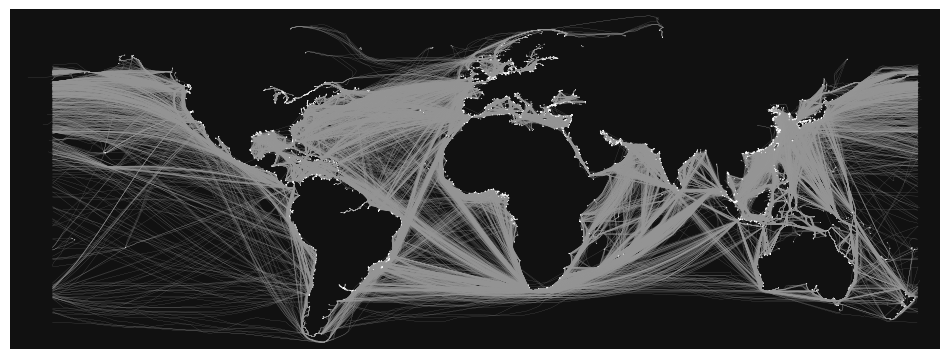

In [46]:
fig, ax = ox.plot_graph(
    G,
    figsize=(12, 14),
    node_size=0.5,
    edge_linewidth=0.1,
    save=False,
    # filepath="./sea_routes.png",
    dpi=300,
)
# plt.savefig('./sea_routes.png', dpi=300)

## Snap to Graph

In [48]:
df_snapped = gn.pandana_snap_c(
    G, df2, source_crs=wgs, target_crs=azimuthal, add_dist_to_node_col=True
)

In [49]:
df_snapped.rename(
    columns={
        "NN": "end_id",
        "NN_dist": "end_port_dist",
    },
    inplace=True,
)

In [50]:
df_snapped.set_geometry("prev_geometry", inplace=True)

In [51]:
df_snapped.geometry

0              POINT (1.08364 49.43863)
1              POINT (4.36273 51.20349)
2              POINT (1.08392 49.43855)
3              POINT (4.94167 52.38167)
4              POINT (3.81155 51.34228)
                       ...             
15312302     POINT (-80.72000 -0.93000)
15312303     POINT (-79.91500 -2.27833)
15312304    POINT (-77.15557 -12.04702)
15312305      POINT (-79.64306 0.99516)
15312306    POINT (-77.14255 -12.03974)
Name: prev_geometry, Length: 15312307, dtype: geometry

In [52]:
df_snapped = gn.pandana_snap_c(
    G, df_snapped, source_crs=wgs, target_crs=azimuthal, add_dist_to_node_col=True
)

In [53]:
df_snapped.rename(
    columns={
        "NN": "start_id",
        "NN_dist": "start_port_dist",
    },
    inplace=True,
)

In [54]:
df3 = df_snapped.loc[df_snapped.start_id != df_snapped.end_id].copy()

In [55]:
print(f"Reduced from {len(df2)} to {len(df3)}")

Reduced from 15312307 to 11171321


In [56]:
del df2
del df_snapped

In [57]:
len(df3)

11171321

### Check if route is already in distances 

In [58]:
distances = ox.graph_to_gdfs(G, nodes=False, edges=True)

In [59]:
distances.reset_index(inplace=True)

In [60]:
distances.head()

,u,v,key,geometry,trip_count,distance,frequency,n_components,land_intersect,index,n_vertices
0,4410,3658,0,"LINESTRING (-87.05329 45.76483, -87.03822 45.6...",1984063,460.638148,1.000000,1.0,1.0,7682,43
1,3658,7083,0,"LINESTRING (-87.49139 41.67484, -87.47907 41.8...",1948666,372.753814,1.000000,1.0,1.0,7062,57
2,3658,2814,0,"LINESTRING (-87.49139 41.67484, -87.44465 41.7...",1950240,362.893147,1.000000,1.0,1.0,7133,61
3,3658,7074,0,"LINESTRING (-87.49139 41.67484, -87.44249 41.9...",2872419,357.698743,1.000000,1.0,1.0,9998,65
4,3658,7069,0,"LINESTRING (-87.49139 41.67484, -87.45370 41.7...",1907240,518.318929,0.428571,1.0,1.0,6380,75


In [61]:
df4 = df3.copy()

In [62]:
# df4.loc[:, "sea_route"] = False

In [63]:
def check_route(row):
    find_route = distances.loc[
        (distances.u == row.start_id) & (distances.v == row.end_id)
    ].copy()
    if len(find_route) > 0:
        return True
    else:
        return False

In [64]:
df4.loc[:, "sea_route"] = df4.parallel_apply(lambda x: check_route(x), axis=1)

In [65]:
df4["sea_route"].isna().sum()

0

In [66]:
# for idx, row in tqdm(df4.iterrows()):
#     find_route = distances.loc[(distances.u==row.start_id) & (distances.v==row.end_id)].copy()
#     if len(find_route) > 0:
#         df4.loc[idx, "sea_route"] = True

In [67]:
df4.sea_route.value_counts()

sea_route
False    8455581
True     2715740
Name: count, dtype: int64

In [69]:
df4.to_parquet(join(expanduser("~"), "tmp", "ais", "portcalls_v3.parquet"), index=False)

In [70]:
# df4.to_csv(join(expanduser("~"), 'tmp', 'ais', 'portcalls_v3.csv'), index=False)

In [71]:
# del(df3)

### Reload

In [72]:
# df4 = pd.read_csv(join(expanduser("~"), 'tmp', 'ais', 'portcalls_v3.csv'))

In [73]:
# df4.loc[:, "geometry"] = df4.apply(lambda x: loads(x.geometry), axis=1)
# df4.loc[:, "prev_geometry"] = df4.apply(lambda x: loads(x.prev_geometry), axis=1)

## Routing

In [74]:
df_found = df4.loc[df4.sea_route == True].copy()
df_search = df4.loc[df4.sea_route == False].copy().reset_index(drop=True)

### Get Distance From Existing Routes

In [75]:
len(df_found), len(df_search)

(2715740, 8455581)

In [76]:
distances.sort_values(["u", "v", "distance"], inplace=True)

In [77]:
distances.head()

,u,v,key,geometry,trip_count,distance,frequency,n_components,land_intersect,index,n_vertices
33466,26,1940,0,"MULTILINESTRING ((-123.32715 48.40278, -123.31...",703167,10030.106970,0.200000,2.0,0.000181,12002821,544
33467,26,1940,1,"MULTILINESTRING ((-123.32715 48.40278, -123.53...",1806381,13940.290558,0.800000,2.0,0.002746,12073163,725
33464,26,1973,0,"MULTILINESTRING ((-123.32715 48.40278, -123.46...",1121874,7091.474099,0.100000,2.0,0.000337,11027902,742
33459,26,1975,1,"MULTILINESTRING ((-123.32715 48.40278, -123.33...",2274155,14513.972521,0.666667,2.0,0.000000,6125524,882
33458,26,1975,0,"MULTILINESTRING ((-123.32715 48.40278, -123.33...",120059,20701.123726,0.333333,2.0,0.000000,5954058,827


In [78]:
def get_distance(row):
    distance = distances.loc[
        (distances.u == row.start_id) & (distances.v == row.end_id)
    ].iloc[0]["distance"]
    return distance

In [79]:
df_found.loc[:, "distance"] = df_found.parallel_apply(lambda x: get_distance(x), axis=1)
# df_found.loc[:, "distance"] = df_found.apply(lambda x: get_distance(x), axis=1)

In [80]:
df_found["distance"].isna().sum()

0

### Get Distance from Graph Routing

In [81]:
import multiprocessing

multiprocessing.cpu_count()

256

In [82]:
# df_sub = df_search.head(100000).copy().reset_index(drop=True)

In [83]:
len(df_search)  # , len(df_sub)

8455581

4 minutes without cpu

In [84]:
%%time
routes = ox.shortest_path(
    G, list(df_search.start_id), list(df_search.end_id), weight="distance", cpus=12
)

In [85]:
len(routes)

340

In [86]:
df_search.loc[:, "route"] = routes

In [87]:
df_search.iloc[0].route

[2815, 2560, 3945]

In [88]:
# route = ox.utils_graph.route_to_gdf(G, routes[0], "distance")

In [89]:
def get_distance_graph(route):
    if route is not None:
        route_distance = ox.utils_graph.route_to_gdf(G, route, "distance")
        return route_distance["distance"].sum()
    else:
        return None

In [90]:
df_search.loc[:, "distance"] = df_search.parallel_apply(
    lambda x: get_distance_graph(x["route"]), axis=1
)

In [91]:
df_search["distance"].isna().sum()

47

In [92]:
len(df_search.loc[~df_search["distance"].isna()])

293

In [93]:
len(df_search.loc[df_search["distance"].isna()]) / len(df_search)

0.13823529411764707

In [94]:
row = df_search.loc[df_search["distance"].isna()].iloc[0].copy()

In [95]:
# row

In [96]:
route = ox.shortest_path(G, int(row.start_id), int(row.end_id), weight="distance")
route

In [97]:
df_new = pd.concat([df_found, df_search])

In [98]:
df_new.reset_index(inplace=True, drop=True)

In [99]:
# df_new.to_csv(join(expanduser("~"), 'tmp', 'ais', 'portcalls_v4.csv'), index=False)
# df_new.to_parquet(
#     join(expanduser("~"), "tmp", "ais", "portcalls_v4.parquet"), index=False
# )

## Filter and Aggregate

In [100]:
# df_new.loc[~df_new['distance'].isna()]['year']

In [101]:
# df_new.arrival_dt_pos_utc = pd.to_datetime(df_new.arrival_dt_pos_utc)

In [102]:
# df_new.loc[:, "year-month"] = df_new.loc[:, "arrival_dt_pos_utc"].dt.strftime("%Y-%m")

In [103]:
df_new.columns

Index(['mmsi', 'imo', 'vessel_name', 'route_group', 'length', 'width',
       'longitude', 'latitude', 'departure_longitude', 'departure_latitude',
       'vessel_type', 'arrival_dt_pos_utc', 'departure_dt_pos_utc',
       'arrival_draught', 'arrival_destination', 'departure_draught',
       'departure_destination', 'mean_sog', 'max_sog', 'min_sog', 'count_ais',
       'year', 'month', 'Country', 'Port', 'geometry',
       'prev_departure_dt_pos_utc', 'time_spent', 'time_travel', 'days_spent',
       'days_travel', 'unique_id', 'prev_geometry', 'prev_port',
       'prev_country', 'travel_distance', 'end_id', 'end_port_dist',
       'start_id', 'start_port_dist', 'sea_route', 'distance', 'route'],
      dtype='object')

In [104]:
group_cols = [
    "year",
    "month",
    "vessel_type",
    "Country",
    "Port",
    "prev_country",
    "prev_port",
]
data_cols = ["time_travel", "distance"]

In [105]:
df_filt = df_new.loc[~df_new["distance"].isna()].copy()

In [106]:
len(df_filt) / len(df_new)

0.9220563847429519

In [107]:
aois = ["Bab el-Mandeb Strait", "Cape of Good Hope", "Suez Canal"]

In [108]:
df_filt.loc[df_filt.Port == "Suez Canal", "Country"] = "Chokepoint Suez Canal"
df_filt.loc[
    df_filt.Port == "Cape of Good Hope", "Country"
] = "Chokepoint Cape of Good Hope"
df_filt.loc[
    df_filt.Port == "Bab el-Mandeb Strait", "Country"
] = "Chokepoint Bab el-Mandeb Strait"

In [109]:
df_filt.loc[df_filt.prev_port == "Suez Canal", "prev_country"] = "Chokepoint Suez Canal"
df_filt.loc[
    df_filt.prev_port == "Cape of Good Hope", "prev_country"
] = "Chokepoint Cape of Good Hope"
df_filt.loc[
    df_filt.prev_port == "Bab el-Mandeb Strait", "prev_country"
] = "Chokepoint Bab el-Mandeb Strait"

In [110]:
df_filt = df_filt.loc[df_filt["Country"] != df_filt["prev_country"]].copy()

In [111]:
len(df_filt) / len(df_new)

0.6849087893864013

In [112]:
len(df_filt)

413

In [113]:
# df_filt.loc[410609]

In [114]:
df_filt2 = df_filt.loc[(df_filt.Port.isin(aois)) | (df_filt.prev_port.isin(aois))].copy()

In [115]:
len(df_filt), len(df_filt2)

(413, 2)

In [116]:
G = ox.distance.add_edge_lengths(G)

In [132]:
# route = df_filt.loc[410609]['route']
# route = df_filt2.iloc[1]["route"]
trip = df_filt2.iloc[1]
trip

mmsi                                                                 218553000
imo                                                                    9197478
vessel_name                                                             WIEBKE
route_group                                                                  3
length                                                                   152.0
width                                                                     20.0
longitude                                                            32.582492
latitude                                                             29.954372
departure_longitude                                                  32.563333
departure_latitude                                                   29.931667
vessel_type                                                              Cargo
arrival_dt_pos_utc                                         2023-01-29 19:49:59
departure_dt_pos_utc                                

In [133]:
trip.start_id, trip.end_id

(2866, 'Suez Canal')

In [134]:
# r = ox.shortest_path(
#     G, 2866, 2214, weight="distance"
# )

In [150]:
trip.end_id

'Suez Canal'

In [154]:
r = ox.shortest_path(
    G, trip.start_id, trip.end_id, weight="distance"
)

ValueError: orig and dest must either both be iterable or neither must be iterable

In [155]:
r

[[2866,
  'Cape of Good Hope',
  2053,
  27090,
  2111,
  'Bab el-Mandeb Strait',
  5322,
  6972,
  'Suez Canal']]

In [153]:
# route = [trip.start_id, trip.end_id]
route = trip.route
route

[2866,
 'Cape of Good Hope',
 2053,
 27090,
 2111,
 'Bab el-Mandeb Strait',
 5322,
 6972,
 'Suez Canal']

In [139]:
route

[2866,
 'Cape of Good Hope',
 2053,
 27090,
 2111,
 'Bab el-Mandeb Strait',
 5322,
 6972,
 'Suez Canal']

In [140]:
# edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
# edges.reset_index(inplace=True)

In [141]:
# edges.head()

In [142]:
# edges.loc[(edges.u==2866) & (edges.v==842)]#.iloc[[0]].explore() #.explore()

In [143]:
# edges.loc[2866, 842].explore()

In [144]:
# ox.utils_graph.route_to_gdf(G, route, "distance")

In [147]:
route

[2866,
 'Cape of Good Hope',
 2053,
 27090,
 2111,
 'Bab el-Mandeb Strait',
 5322,
 6972,
 'Suez Canal']

NotImplementedError: 

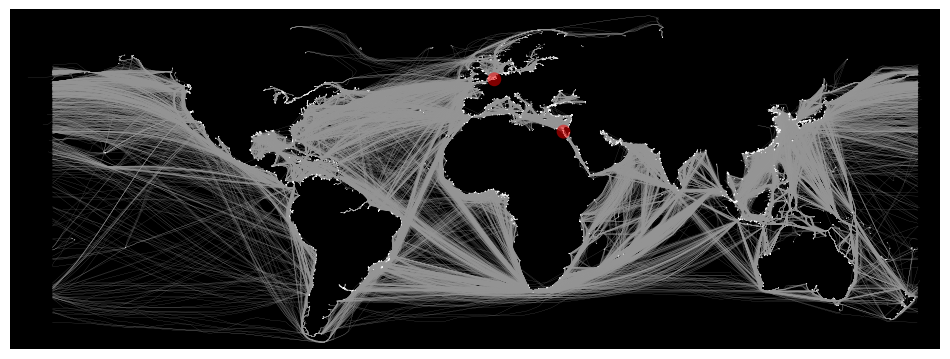

In [146]:
ox.plot_graph_route(
    G,
    route,
    figsize=(12, 14),
    route_linewidth=6,
    node_size=0.5,
    edge_linewidth=0.1,
    bgcolor="k",
    route_color="r",
    save=False,
    # filepath="./route.png",
    dpi=300,
)

In [ ]:
# ox.plot_graph_route(
#     G,
#     route,
#     route_linewidth=6,
#     node_size=0.5,
#     bgcolor="k",
#     route_color="r",
#     save=False,
#     # filepath="./route.png",
#     dpi=300,
# )

In [ ]:
fig, ax = ox.plot_graph(
    G,
    figsize=(12, 14),
    node_size=0.5,
    edge_linewidth=0.1,
    save=True,
    filepath="./sea_routes.png",
    dpi=300,
)

In [122]:
# df_filt.to_parquet(
#     join(expanduser("~"), "tmp", "ais", "portcalls_v5.parquet"), index=False
# )

In [153]:
df_filt.to_csv(join(expanduser("~"), "tmp", "ais", "portcalls_v5.csv"), index=False)

In [157]:
%%time
df_agg = df_filt.groupby(group_cols)[data_cols].sum()

CPU times: user 895 ms, sys: 54.7 ms, total: 950 ms
Wall time: 1.12 s


In [158]:
len(df_agg)

456357

In [159]:
df_agg = df_agg.reset_index()

In [160]:
df_agg.to_csv(join(expanduser("~"), "tmp", "ais", "port_calls_agg_v3.csv"), index=False)